# Twitter analysis of climate change perceptions

In [1]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

# Text processing tools
import tweepy
from textblob import TextBlob, Word
import re, nltk, gensim, spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Visualization libraries
from geopy.geocoders import Nominatim
import gmplot
import pyLDAvis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [3]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

<>:16: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \w
<>:16: DeprecationWarning: invalid escape sequence \w
<ipython-input-3-a253394184cf>:16: DeprecationWarning: invalid escape sequence \w
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


In [4]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environment")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(150):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [5]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1180918854408650752,Ridicule of climate change is warranted by the name It should be called CLIMATE DESTRUCTION because that is what,139,2019-10-06 18:52:49,"Fort Lauderdale, FL",[],0.000000,Neutral
1,1180918513734684672,Tomorrow at 10 AM YellowTapeCRK will be going live on An interesting conversation on,136,2019-10-06 18:51:28,"Nairobi, KE","[{'text': 'YellowTapeCRK', 'indices': [19, 33]}]",0.318182,Positive
2,1180918509397778432,The water looks a little close ClimateChange,73,2019-10-06 18:51:27,Georgia USA,"[{'text': 'ClimateChange', 'indices': [35, 49]}]",-0.187500,Negative
3,1180918185396199424,Come remember a happylife w a mom facing execution in a thrilling familydrama set amid ecologicalcollapse,137,2019-10-06 18:50:10,"California, USA","[{'text': 'happylife', 'indices': [16, 26]}, {'text': 'execution', 'indices': [43, 53]}, {'text': 'thrilling', 'indices': [59, 69]}, {'text': 'familydrama', 'indices': [70, 82]}, {'text': 'ecologicalcollapse', 'indices': [92, 111]}]",0.250000,Positive
4,1180918160217784321,I agree the tactics used a,140,2019-10-06 18:50:04,"Bristol, England",[],0.000000,Neutral


### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [6]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['ridicule',
  'of',
  'climate',
  'change',
  'is',
  'warranted',
  'by',
  'the',
  'name',
  'it',
  'should',
  'be',
  'called',
  'climate',
  'destruction',
  'because',
  'that',
  'is',
  'what'],
 ['tomorrow',
  'at',
  '10',
  'am',
  'yellowtapecrk',
  'will',
  'be',
  'going',
  'live',
  'on',
  'an',
  'interesting',
  'conversation',
  'on']]

In [7]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['ridicule',
  'climate',
  'change',
  'warranted',
  'name',
  'called',
  'climate',
  'destruction'],
 ['tomorrow',
  '10',
  'yellowtapecrk',
  'going',
  'live',
  'interesting',
  'conversation']]

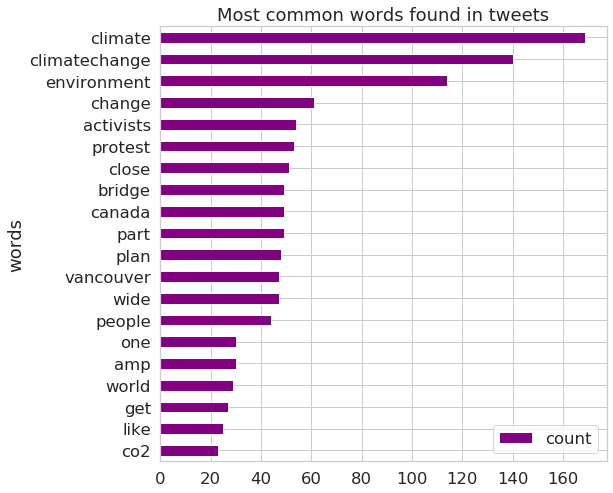

In [8]:
# Flatten list of words in clean tweets
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

In addition to removal of stopwords, we will also create a collection of our own topic related words. Since we have  used "climated change" as a collection term, this term appear in every collected tweet. Therefore, we can expect that these terms will dominate the list of the most frequent words. In order to obtain new insight into the perceptions of twitter users we remove the search words from tweets through list comprehension.

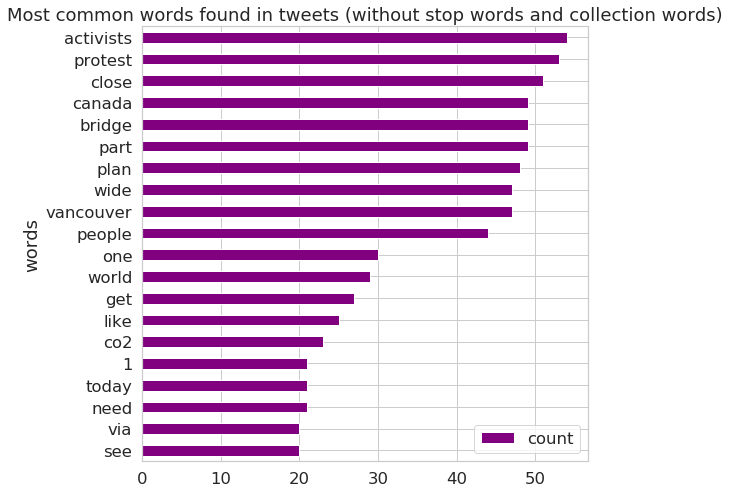

In [9]:
# Create a list of words to remove
remove_words = ("#ClimateChange", "Environment", "climate", "climatechange", "change", "amp", "much", "environment")

# Remove search words and rerun word frequency plot
tweets_nsw_rsw = [[w for w in word if not w in remove_words]
                  for word in tweets_nsw]

# Flatten list of words in clean tweets
all_words_nsw_rsw = list(itertools.chain(*tweets_nsw_rsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw_rsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets (without stop words and collection words)")
plt.show()

In next section I will explore the co-occuring words (bigrams) in the tweets. Analysis of bigrams provides deeper understanding compared to single words.

In [10]:
# Create a list of lists containing bigrams in tweets
tweet_bigrams = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_rsw]

# Display bigrams from the first tweet
tweet_bigrams[0]

[('ridicule', 'warranted'),
 ('warranted', 'name'),
 ('name', 'called'),
 ('called', 'destruction')]

In [11]:
# Display the original tweet 
tweets_df.text[0]

'Ridicule of climate change is warranted by the name It should be called CLIMATE DESTRUCTION because that is what'

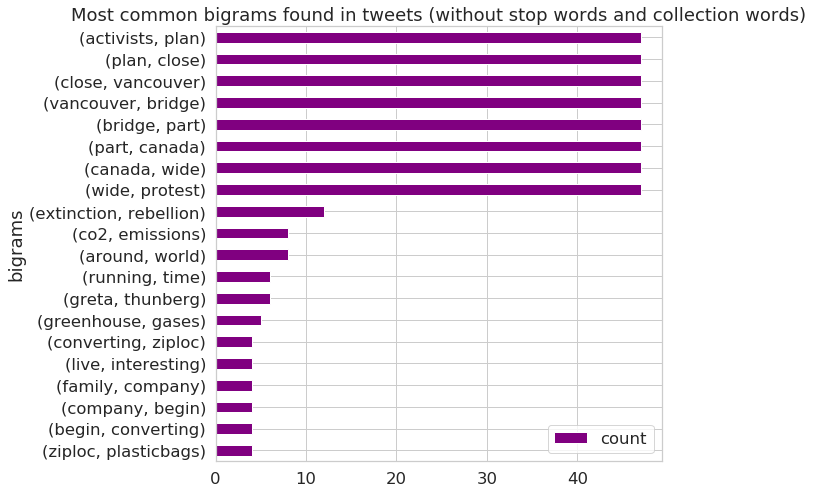

In [12]:
# Flatten list of bigrams
bigrams = list(itertools.chain(*tweet_bigrams))

# Create a counter of most frequent bigrams
bigrams_count = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigrams_count.most_common(20),
                         columns=['bigrams', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
bigram_df.sort_values(by='count').plot.barh(x='bigrams',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common bigrams found in tweets (without stop words and collection words)")
plt.show()

### Geospatial analysis
Next we will look at where are people tweeting from.

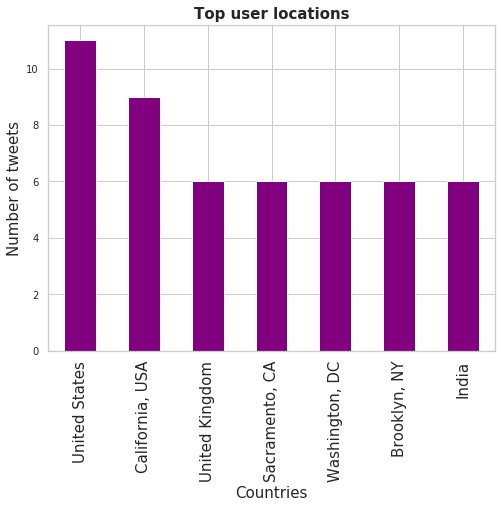

In [13]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')

To get better sense of where the majority of tweets are coming from we will use the user locations in text format such as "London, England" and transform it into latitude and longitude coordinates. Having the coordinates we can create a heatmap visualization.

In [26]:
# Plot user locations on heatmap
geoloc = Nominatim()


# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}  

for count, user_loc in enumerate(tweets_df.user_location):  
    try:
        location = geoloc.geocode(user_loc)
        

        # If coordinates are found for location append them and wait so the TimeOut Error is not raised
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            time.sleep(0.5)

    # If too many connection requests
    except:
        pass

# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("vis/tweets_heatmap.html")

### Sentiment analysis
Sentiment analysis or otherwise known as opinion mining, looks at the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within a text. Sentiment analysis is extremely useful in social media monitoring as it allows us to gain an overview of the wider public opinion behind the analysed topic. 

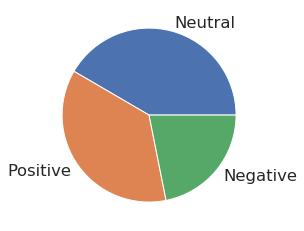

In [14]:
# Plot pie chart of sentiment classes
tweets_sentiment = tweets_df['sentiment_class'].value_counts()

# Create a pie chart
plt.pie(tweets_sentiment, labels=tweets_sentiment.index)
plt.show()

In [15]:
# Print descriptive statistics
tweets_df.sentiment.describe()

count    750.000000
mean     0.079772  
std      0.252054  
min     -0.800000  
25%      0.000000  
50%      0.000000  
75%      0.165476  
max      1.000000  
Name: sentiment, dtype: float64

In [16]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmax()]

'Check out this week s episode of Legendary abalone fisherman Jack Likins and I go diving with'

In [17]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmin()]

'Oh A climate moron Nevermind'

### Topic modeling
Topic Modeling is a form of unsupervised learning used for identifying common “topics” in large clusters of texts.
Topics can be defined as a repeating pattern of co-occurring terms in a corpus.

To compare the agruments used by twitter users we will look at how the topics differ for positive and negative tweets. 

In [18]:
# Create a column of tweets excluding stopwords
tweets_df['clean_text']=tweets_nsw

# Create a list of positive and negative tweets
positive_tweets = tweets_df.clean_text.loc[tweets_df['sentiment'] >= 0.4]
negative_tweets = tweets_df.clean_text.loc[tweets_df['sentiment'] <= -0.4]

In [19]:
# Define a function which will lemmatize words. This will transfrom words to its base form
def lemmatization(tweets_nsw , allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """ Lemmetize tweets  

    Parameters
    ----------
    tweets_nsw : list 
        A list of tweets excluding stop words
    
    Returns
    -------
    List of lemmetized tweets
    """
    texts_out = []
    for tweet in tweets_nsw:
        doc = nlp(" ".join(tweet)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
positive_tweets_lemmatized = lemmatization(positive_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_tweets_lemmatized = lemmatization(negative_tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(negative_tweets_lemmatized[:5])

/home/ivana/anaconda3/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/home/ivana/anaconda3/lib/python3.7/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)


['aarey tree cut supreme court take suo motu cognisance hear october saveaareysavemumbai savetree', 'steamdrill climatechange signal light coal coal human become extinct riverasunauthor', 'make feel bad dramatic speech offer solution call', 'bad environment', 'reflection environment time scarily do not see thing wrong fic']


In [21]:
# Transform tweets into a word matrix 
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum required occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # number of word characters > 3
                            )

positive_vectorized = vectorizer.fit_transform(positive_tweets_lemmatized)
negative_vectorized = vectorizer.fit_transform(negative_tweets_lemmatized)

In [22]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

positive_lda = lda_model.fit_transform(positive_vectorized)
negative_lda = lda_model.fit_transform(negative_vectorized)

In [36]:
# Define Search Parameters to find the optimal number of topics in text and learning decay rate
search_params = {'n_components': [3,4,5,7], 'learning_decay': [.2, .5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method = 'batch')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid = search_params, iid = False)

# Do the Grid Search
model.fit(positive_vectorized)

# Do the Grid Search
model.fit(negative_vectorized)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'n_components': [3, 4, 5, 7], 'learning_decay': [0.2, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
# Best Model
best_lda_model = model.best_estimator_

In [38]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [39]:
# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}


In [40]:
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

Best Log Likelihood Score:  -21.135842254989907


In [51]:
# Create visialisation of the LDA model using pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_lda_model, positive_vectorized, vectorizer, mds='tsne')
panel

AttributeError: module 'pyLDAvis' has no attribute 'gensim'

In [52]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(best_lda_model, positive_vectorized, vectorizer, mds='tsne')
pyLDAvis.display(lda_display)

AttributeError: 'CountVectorizer' object has no attribute 'token2id'